In [1]:
!wget https://storage.googleapis.com/open_source_datasets/ShelfImages.tar.gz
!tar -xvzf ShelfImages.tar.gz
!git clone https://github.com/gulvarol/grocerydataset.git
!wget https://github.com/gulvarol/grocerydataset/releases/download/1.0/GroceryDataset_part2.tar.gz
!tar -xvzf GroceryDataset_part2.tar.gz
!pip install tensorflow-object-detection-api

Streaming output truncated to the last 5000 lines.
ProductImagesFromShelves/0/C1_P02_N2_S2_1.JPG_1088_1632_340_584.png
BrandImagesFromShelves/6/C1_P08_N3_S3_1.JPG_1904_892_216_368.png
ProductImagesFromShelves/0/C2_P06_N1_S4_1.JPG_1172_928_164_220.png
ProductImagesFromShelves/0/C4_P02_N2_S3_1.JPG_340_332_164_228.png
ProductImagesFromShelves/0/C4_P08_N1_S2_1.JPG_2556_620_244_392.png
ProductImagesFromShelves/0/C1_P08_N3_S4_2.JPG_2820_920_200_340.png
ProductImagesFromShelves/2/C4_P03_N1_S4_1.JPG_1476_656_168_240.png
BrandImagesFromShelves/2/C4_P03_N2_S3_2.JPG_332_296_192_264.png
ProductImagesFromShelves/0/C3_P07_N4_S2_1.JPG_3760_504_412_564.png
ProductImagesFromShelves/0/C1_P08_N1_S4_1.JPG_1976_1436_212_324.png
ProductImagesFromShelves/0/C3_P07_N2_S3_1.JPG_2720_1096_292_408.png
ProductImagesFromShelves/0/C3_P03_N1_S5_1.JPG_644_2140_152_276.png
ProductImagesFromShelves/0/C1_P03_N1_S2_1.JPG_2772_1120_220_320.png
ProductImagesFromShelves/0/C1_P02_N2_S4_1.JPG_464_1400_264_380.png
BrandImagesFr

In [3]:
%tensorflow_version 1.x
import cv2
import pandas as pd
from matplotlib import pyplot as plt
import os
import numpy as np
from sklearn.model_selection import train_test_split

import io
import tensorflow as tf

from PIL import Image
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict

%matplotlib inline

In [4]:
data_path = './'
# we'll use data from two folders
shelf_images = './ShelfImages/train/'
shelf_images_test = './ShelfImages/test/'
product_images = './ProductImagesFromShelves/'

# current images path 
img_path = './ShelfImages/train/'
# cropped parts destination
cropped_path = './detector/'
# Step 1 results path
data_path = './'
# output destination
detector_data_path = './pack_detector/data/'

In [5]:
!mkdir detector
!mkdir detector/eval
!mkdir detector/train
!mkdir pack_detector
!mkdir pack_detector/data

In [6]:
# let's get all shelves photo data from ShelfImages
jpg_files = [f for f in os.listdir(f'{shelf_images}') if f.endswith('JPG')]
photos_df = pd.DataFrame([[f, f[:6], f[7:14]] for f in jpg_files], 
                         columns=['file', 'shelf_id', 'planogram_id'])
photos_df.head()

,file,shelf_id,planogram_id
0,C3_P01_N2_S2_1.JPG,C3_P01,N2_S2_1
1,C2_P02_N4_S2_1.JPG,C2_P02,N4_S2_1
2,C3_P05_N1_S4_1.JPG,C3_P05,N1_S4_1
3,C3_P05_N2_S2_1.JPG,C3_P05,N2_S2_1
4,C2_P07_N2_S3_1.JPG,C2_P07,N2_S3_1


In [7]:
# let's get products on shelves photo from ProductImagesFromShelves
products_df = pd.DataFrame(
    [[f[:18], f[:6], f[7:14], i, *map(int, f[19:-4].split('_'))] 
     for i in range(11) 
     for f in os.listdir(f'{product_images}{i}') if f.endswith('png')],
    columns=['file', 'shelf_id', 'planogram_id', 
             'category', 'xmin', 'ymin', 'w', 'h'])
# convert from width height to xmax, ymax
products_df['xmax'] = products_df['xmin'] + products_df['w']
products_df['ymax'] = products_df['ymin'] + products_df['h']
products_df.head()

,file,shelf_id,planogram_id,category,xmin,ymin,w,h,xmax,ymax
0,C2_P08_N1_S6_1.JPG,C2_P08,N1_S6_1,0,680,372,120,164,800,536
1,C2_P01_N4_S2_1.JPG,C2_P01,N4_S2_1,0,1344,864,176,248,1520,1112
2,C4_P03_N3_S3_2.JPG,C4_P03,N3_S3_2,0,2392,940,212,344,2604,1284
3,C4_P05_N1_S4_1.JPG,C4_P05,N1_S4_1,0,2256,1156,196,308,2452,1464
4,C3_P07_N3_S3_1.JPG,C3_P07,N3_S3_1,0,668,1944,300,320,968,2264


In [8]:
# get distinct shelves
shelves = list(set(photos_df['shelf_id'].values))
# use train_test_split from sklearn
shelves_train, shelves_validation, _, _ = train_test_split(
    shelves, shelves, test_size=0.3, random_state=6)
# mark all records in data frames with is_train flag
def is_train(shelf_id): return shelf_id in shelves_train
photos_df['is_train'] = photos_df.shelf_id.apply(is_train)
products_df['is_train'] = products_df.shelf_id.apply(is_train)

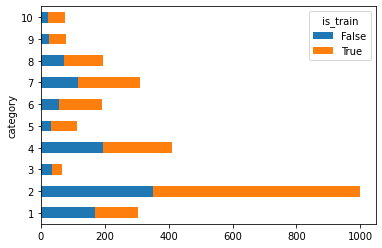

In [9]:
df = products_df[products_df.category != 0].\
         groupby(['category', 'is_train'])['category'].\
         count().unstack('is_train').fillna(0)
df.plot(kind='barh', stacked=True)

In [13]:
# save to pkl
photos_df.to_pickle(f'{data_path}photos.pkl')
products_df.to_pickle(f'{data_path}products.pkl')

In [ ]:
########Get best fit for the anchor box#######

In [14]:
def iou(box, clusters):
    """
    Calculates the Intersection over Union (IoU) between a box and k clusters.
    :param box: tuple or array, shifted to the origin (i. e. width and height)
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: numpy array of shape (k, 0) where k is the number of clusters
    """
    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])
    if np.count_nonzero(x == 0) > 0 or np.count_nonzero(y == 0) > 0:
        raise ValueError("Box has no area")

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_


def avg_iou(boxes, clusters):
    """
    Calculates the average Intersection over Union (IoU) between a numpy array of boxes and k clusters.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: average IoU as a single float
    """
    return np.mean([np.max(iou(boxes[i], clusters)) for i in range(boxes.shape[0])])


def translate_boxes(boxes):
    """
    Translates all the boxes to the origin.
    :param boxes: numpy array of shape (r, 4)
    :return: numpy array of shape (r, 2)
    """
    new_boxes = boxes.copy()
    for row in range(new_boxes.shape[0]):
        new_boxes[row][2] = np.abs(new_boxes[row][2] - new_boxes[row][0])
        new_boxes[row][3] = np.abs(new_boxes[row][3] - new_boxes[row][1])
    return np.delete(new_boxes, [0, 1], axis=1)

In [15]:
def kmeans(boxes, k, dist=np.median):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances = np.empty((rows, k))
    last_clusters = np.zeros((rows,))

    np.random.seed()

    # the Forgy method will fail if the whole array contains the same rows
    clusters = boxes[np.random.choice(rows, k, replace=False)]

    while True:
        for row in range(rows):
            distances[row] = 1 - iou(boxes[row], clusters)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break

        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters

In [16]:
from sklearn.cluster import KMeans

data = np.array(products_df[['w', 'h']])

k = 3
out = kmeans(data, k=k)
print("Accuracy: {:.2f}%".format(avg_iou(data, out) * 100))
print("Boxes:\n {}".format(out))

ratios = np.around(out[:, 0] / out[:, 1], decimals=2).tolist()
print("Ratios:\n {}".format(sorted(ratios)))

Accuracy: 81.59%
Boxes:
 [[116 168]
 [232 364]
 [180 268]]
Ratios:
 [0.64, 0.67, 0.69]


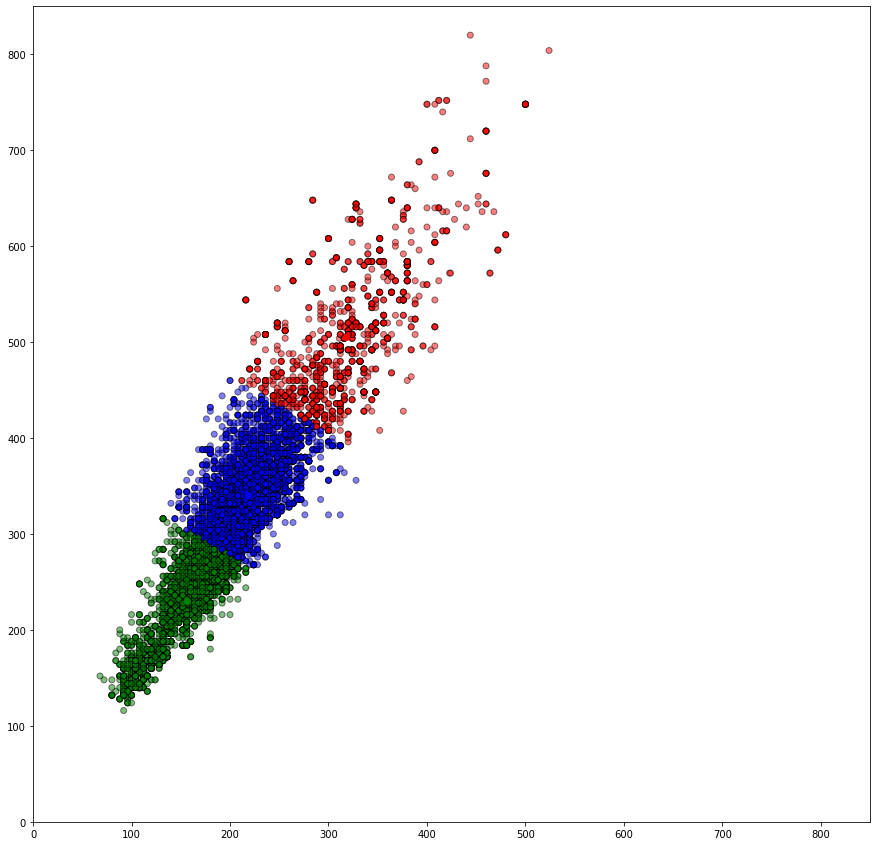

In [18]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=k)
kmeans.fit(data)

labels = kmeans.predict(data)
centroids = kmeans.cluster_centers_
colmap = {1: 'red', 2: 'green', 3: 'blue', 4:'cyan', 5:'yellow', 6:'magenta'}

fig = plt.figure(figsize=(15, 15))

colors = list(map(lambda x: colmap[x+1], labels))
# print(colors)

plt.scatter(products_df["w"],products_df['h'], color=colors, alpha=0.5, edgecolor='k')
for idx, centroid in enumerate(centroids):
    plt.scatter(*centroid, color=colmap[idx+1])
plt.xlim(0, 850)
plt.ylim(0, 850)
# plt.show()
plt.savefig('k-mean.png')

In [ ]:
#####GOT K=0.64 as best ratio for the anchor box#####

In [19]:
# function to display shelf photo with rectangled products
def draw_shelf_photo(file):
    file_products_df = products_df[products_df.file == file]
    coordinates = file_products_df[['xmin', 'ymin', 'xmax', 'ymax']].values
    im = cv2.imread(f'{shelf_images}{file}')
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)    
    for xmin, ymin, xmax, ymax in coordinates:
        cv2.rectangle(im, (xmin, ymin), (xmax, ymax), (0, 255, 0), 5)
    plt.imshow(im)

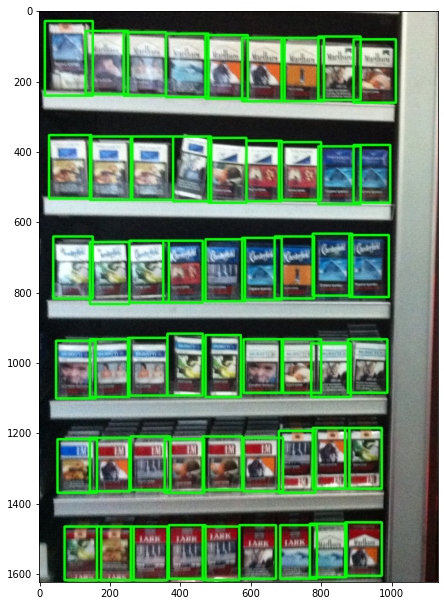

In [20]:
# draw one photo to check our data
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
draw_shelf_photo('C2_P08_N1_S6_1.JPG')

In [24]:
# read rects and photos dataframes
photos = pd.read_pickle(f'{data_path}photos.pkl')
products = pd.read_pickle(f'{data_path}products.pkl')

In [ ]:
####CREATE RECORDS AND DATA 

In [25]:
N_CROP_TRIALS = 6
CROP_SIZE = 1000

In [26]:
# returns random value in [s, f]
def rand_between(s, f):
    if s == f:
        return s
    return np.random.randint(s, f)

In [27]:
train_products, eval_products = [], []
for img_file, is_train in photos[['file', 'is_train']].values:
    #print(img_file)
    img = cv2.imread(f'{img_path}{img_file}')
    #print(img)
    img_h, img_w, img_c = img.shape
    for n in range(N_CROP_TRIALS):
        # randomly crop square
        c_size = rand_between(300, max(img_h, img_w))
        x0 = rand_between(0, max(0, img_w - c_size))
        y0 = rand_between(0, max(0, img_h - c_size))
        x1 = min(img_w, x0 + c_size)
        y1 = min(img_h, y0 + c_size)
        # products totally inside crop rectangle
        crop_products = products[(products.file == img_file) & 
                                 (products.xmin > x0) & (products.xmax < x1) &
                                 (products.ymin > y0) & (products.ymax < y1)]
        # no products inside crop rectangle? cropping trial failed...
        if len(crop_products) == 0:
            continue
        # name the crop
        crop_img_file = f'{img_file[:-4]}{x0}_{y0}_{x1}_{y1}.JPG'
        # crop and reshape to CROP_SIZExCROP_SIZE or smaller 
        # keeping aspect ratio
        crop = img[y0:y1, x0:x1]
        h, w, c = crop.shape
        ratio = min(CROP_SIZE/h, CROP_SIZE/w)
        crop = cv2.resize(crop, (0,0), fx=ratio, fy=ratio)
        crop = crop[0:CROP_SIZE, 0:CROP_SIZE]
        h, w, c = crop.shape
        # add crop inner products to train_products or eval_products list
        for xmin, ymin, xmax, ymax in \
                crop_products[['xmin', 'ymin', 'xmax', 'ymax']].values:
            xmin -= x0
            xmax -= x0
            ymin -= y0
            ymax -= y0

            xmin, xmax, ymin, ymax = [int(np.round(e * ratio)) 
                                      for e in [xmin, xmax, ymin, ymax]]
            product = {'filename': crop_img_file, 'class':'pack', 
                       'width':w, 'height':h,
                       'xmin':xmin, 'ymin':ymin, 'xmax':xmax, 'ymax':ymax}
            if is_train:
                train_products.append(product)
            else:
                eval_products.append(product)
        # save crop top eval or train folder
        subpath = ['eval/', 'train/'][is_train]
        #print(crop)
        cv2.imwrite(f'{cropped_path}{subpath}{crop_img_file}', crop)

In [29]:
train_df = pd.DataFrame(train_products).set_index('filename')
eval_df = pd.DataFrame(eval_products).set_index('filename')

In [31]:
def class_text_to_int(row_label):
    if row_label == 'pack':
        return 1
    else:
        None


def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) 
            for filename, x in zip(gb.groups.keys(), gb.groups)]


def create_tf_example(group, path):
    with tf.io.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

In [32]:
def convert_to_tf_records(images_path, examples, dst_file):
    writer = tf.io.TFRecordWriter(dst_file)
    grouped = split(examples, 'filename')
    for group in grouped:
        tf_example = create_tf_example(group, images_path)
        writer.write(tf_example.SerializeToString())
    writer.close()

In [33]:
convert_to_tf_records(f'{cropped_path}train/', train_df, f'{detector_data_path}train.record')
convert_to_tf_records(f'{cropped_path}eval/', eval_df, f'{detector_data_path}eval.record')

In [36]:
!cp pack_detector/data/train.record drive/MyDrive/
!cp pack_detector/data/eval.record drive/MyDrive/

In [ ]:
##########RECORDS CREATED##########